In [1]:
import json
import re
import pandas as pd
from pandas.io.json import json_normalize

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 110)

In [2]:
def flattenJSON(json_obj):   
    data = json.loads(json_obj)
    
    def flatten_dict(data):
        for k in list(data):
            if isinstance(data[k], dict):
                child = flatten_dict(data[k])
                for k_ in child:
                    data[k + '.' + k_] = re.sub('^u?\'(.*?)\'','\g<1>',child[k_])
                else:
                    del data[k]
        return data
    
    return flatten_dict(data)

In [3]:
def toConvertableJson(s):    
    def _convertableJson(matchObj):
        if matchObj.group(1):
            return '"'
        elif matchObj.group(2):
            return ':"False"'
        elif matchObj.group(3):
            return ':"True"'
    
    d = flattenJSON(s)
    for i,v in enumerate(d):
        if isinstance(d[v], str) and ('{' in d[v]):
            d[v] = json.loads(re.sub('(\')|(: False)|(: True)',_convertableJson, d[v]))
    return flattenJSON(json.dumps(d))

### Business

In [4]:
with open('yelp_dataset/business.json') as f:
    data = [toConvertableJson(line) for line in f]
business = pd.DataFrame(data)
#business = business.sample(frac=0.05, replace=False, random_state=1)
business.drop(['hours','attributes'], axis=1, inplace=True) # null

In [5]:
#business[business['categories'].apply(lambda x:'Coffee & Tea' in x if x is not None else False)]

In [6]:
restaurant = business[business['categories'].apply(lambda x:('Restaurants' in x) or (('Bars' in x) and ('Cigar Bars' not in x) and ('Oxygen Bars' not in x)) or ('Food' in x) or ('Coffee & Tea' in x) or ('Fast Food' in x) or ('Burger' in x) or ('Pizza' in x) or ('Sandwiches' in x) or ('Breakfast & Brunch' in x) if x is not None else False)]
restaurant = restaurant[restaurant['city']=='Las Vegas']

#### drop features(core)

In [7]:
for i in restaurant.columns:
    if 'Hair' in i:
        restaurant.drop(restaurant[(restaurant[i]=='False') | (restaurant[i]=='True')]['business_id'].index, axis=0, inplace=True)
        restaurant.drop(columns=i, axis=1, inplace=True)

#### drop features(for training)

In [8]:
for i in restaurant.columns:
    if ('hour' in i) or ('Wheelchair' in i):
        restaurant.drop(columns=i, axis=1, inplace=True)

In [9]:
restaurant[restaurant['categories'].apply(lambda x:('Nudist' in x) )]['categories'].values

array(['Nudist, Nightlife, Active Life, Beauty & Spas, Day Spas, Religious Organizations, Lounges, Bars, Adult Entertainment, Dance Clubs, Arts & Entertainment, Buddhist Temples, Social Clubs'],
      dtype=object)

#### check category

In [10]:
cat_col = ['Restaurants', 'Food', 'Bars', 'Fast Food', 'American Traditional)', 'Mexican', 'Coffee & Tea', 'Sandwiches', 'Pizza', 'American New)', 'Burgers', 'Breakfast & Brunch', 'Specialty Food', 'Desserts', 'Chinese', 'Italian', 'Seafood', 'Japanese', 'Bakeries', 'Ice Cream & Frozen Yogurt', 'Asian Fusion', 'Juice Bars & Smoothies', 'Wine & Spirits', 'Beer', 'Sushi Bars', 'Chicken Wings', 'Cafes', 'Salad', 'Steakhouses', 'Barbeque', 'Cocktail Bars', 'Delis', 'Pubs', 'Thai', 'Mediterranean', 'Hawaiian', 'Food Trucks', 'Korean', 'Buffets', 'Vegetarian', 'Vegan', 'Food Delivery Services', 'Diners', 'Ethnic Food', 'Hot Dogs', 'Vietnamese', 'Local Flavor', 'Wine Bars', 'Soup', 'Donuts', 'Bubble Tea', 'Latin American', 'Food Stands', 'Filipino', 'Street Vendors', 'Noodles', 'Tex-Mex', 'Dive Bars', 'Gluten-Free', 'Hookah Bars', 'French', 'Southern', 'Indian', 'Greek', 'Middle Eastern', 'Chocolatiers & Shops', 'Chicken Shop', 'Candy Stores', 'Tapas/Small Plates', 'Shaved Ice', 'Bagels', 'Comfort Food', 'Tacos', 'Tapas Bars', 'Cupcakes', 'Soul Food', 'Gastropubs', 'Ramen', 'Custom Cakes', 'Beer Bar', 'Tea Rooms', 'Cajun/Creole', 'Halal', 'Tobacco Shops', 'Dim Sum', 'Food Court', 'Poke', 'Gelato', 'Breweries', 'Cheesesteaks', 'Fruits & Veggies', 'Spanish', 'Taiwanese', 'Imported Food', 'Pretzels', 'Caribbean', 'Szechuan', 'Pakistani', 'Kosher', 'Creperies', 'Persian/Iranian', 'Salvadoran', 'Cuban', 'Seafood Markets', 'Personal Chefs', 'Hot Pot', 'Ethiopian', 'Herbs & Spices', 'Brazilian', 'Acai Bowls', 'Pasta Shops', 'Waffles', 'Patisserie/Cake Shop', 'Coffeeshops', 'Irish', 'Izakaya', 'Popcorn Shops', 'British', 'Peruvian', 'Wineries', 'Coffee Roasteries', 'Teppanyaki', 'New Mexican Cuisine', 'Live/Raw Food', 'Fish & Chips', 'Piano Bars', 'African', 'Macarons', 'Modern European', 'Lebanese', 'German', 'Singaporean', 'Pan Asian', 'Brasseries', 'Falafel', 'Russian', 'Fondue', 'Shaved Snow', 'Irish Pub', 'Mongolian', 'Afghan', 'Shanghainese', 'Venezuelan', 'Tiki Bars', 'Laotian', 'Malaysian', 'Beverage Store', 'Colombian', 'Beer Gardens', 'Argentine', 'Champagne Bars', 'Japanese Curry', 'Kebab', 'Himalayan/Nepalese', 'Puerto Rican', 'Cafeteria', 'Basque', 'Bed & Breakfast', 'Themed Cafes', 'Honey', 'Turkish', 'Whiskey Bars', 'Tuscan', 'Egyptian', 'Pub Food', 'Moroccan', 'Belgian', 'Ukrainian', 'Airsoft', 'Beach Bars', 'Guamanian', 'Brewpubs', 'Armenian', 'Arabian', 'Conveyor Belt Sushi', 'Portuguese', 'Scandinavian', 'South African', 'Pop-Up Restaurants']
restaurant['categories'] = restaurant['categories'].map(lambda x:','.join([n.strip() for n in x.split(',') if n.strip() in cat_col]))
restaurant.drop(restaurant[restaurant['categories'] == ''].index, axis=0, inplace=True)

In [11]:
max(restaurant['categories'].map(lambda x : len(x.split(','))))

15

In [12]:
cat = []
[cat.extend(n.split(',')) for n in restaurant['categories'] if n is not None ]
cat = [n.strip() for n in cat]
cat = [(n, cat.count(n)) for n in set(cat)]
cat.sort(key=lambda e:e[1], reverse=True)
cat

[('Restaurants', 6450),
 ('Food', 3594),
 ('Bars', 1542),
 ('Fast Food', 985),
 ('Mexican', 827),
 ('Coffee & Tea', 766),
 ('Sandwiches', 741),
 ('Pizza', 686),
 ('Burgers', 622),
 ('Breakfast & Brunch', 543),
 ('Specialty Food', 541),
 ('Desserts', 481),
 ('Chinese', 475),
 ('Italian', 454),
 ('Seafood', 398),
 ('Japanese', 392),
 ('Bakeries', 351),
 ('Ice Cream & Frozen Yogurt', 337),
 ('Asian Fusion', 328),
 ('Juice Bars & Smoothies', 309),
 ('Beer', 309),
 ('Wine & Spirits', 309),
 ('Sushi Bars', 283),
 ('Chicken Wings', 269),
 ('Cafes', 265),
 ('Salad', 259),
 ('Steakhouses', 254),
 ('Barbeque', 246),
 ('Cocktail Bars', 209),
 ('Delis', 206),
 ('Pubs', 189),
 ('Thai', 165),
 ('Mediterranean', 156),
 ('Hawaiian', 149),
 ('Food Trucks', 146),
 ('Buffets', 144),
 ('Korean', 144),
 ('Vegetarian', 138),
 ('Vegan', 137),
 ('Food Delivery Services', 137),
 ('Diners', 128),
 ('Ethnic Food', 120),
 ('Hot Dogs', 114),
 ('Vietnamese', 107),
 ('Local Flavor', 101),
 ('Wine Bars', 94),
 ('Bubb

#### check null

In [13]:
s = pd.DataFrame({'unique_count':restaurant.nunique(),'null_count':restaurant.isnull().sum()})
#s[s['unique_count']==0]
s

,unique_count,null_count
business_id,8864,0
name,6334,0
address,6057,0
city,1,0
state,2,0
postal_code,77,0
latitude,7343,0
longitude,7181,0
stars,9,0
review_count,950,0


In [14]:
restaurant

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,attributes.GoodForMeal.dessert,attributes.GoodForMeal.latenight,attributes.GoodForMeal.lunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.brunch,attributes.GoodForMeal.breakfast,attributes.BusinessParking.garage,attributes.BusinessParking.street,attributes.BusinessParking.validated,attributes.BusinessParking.lot,attributes.BusinessParking.valet,attributes.Ambience.romantic,attributes.Ambience.intimate,attributes.Ambience.classy,attributes.Ambience.hipster,attributes.Ambience.divey,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.Ambience.casual,attributes.BusinessAcceptsCreditCards,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.Music.dj,attributes.Music.background_music,attributes.Music.no_music,attributes.Music.jukebox,attributes.Music.live,attributes.Music.video,attributes.Music.karaoke,attributes.BestNights.monday,attributes.BestNights.tuesday,attributes.BestNights.friday,attributes.BestNights.wednesday,attributes.BestNights.thursday,attributes.BestNights.sunday,attributes.BestNights.saturday,attributes.Ambience,attributes.BusinessParking,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.Corkage,attributes.BYOB,attributes.GoodForMeal,attributes.Music,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.vegetarian,attributes.BestNights,attributes.Open24Hours,attributes.DietaryRestrictions,attributes.RestaurantsCounterService
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,"Restaurants,Italian",True,True,True,quiet,NaN,True,2,False,NaN,False,no,full_bar,casual,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,KWywu2tTEPWmR9JnBc0WyQ,Hunk Mansion,6007 Dean Martin Dr,Las Vegas,NV,89118,36.080168,-115.182756,4.0,107,1,Bars,False,True,NaN,loud,NaN,NaN,2,True,False,True,NaN,full_bar,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,True,False,True,False,False,False,False,False,False,False,True,NaN,NaN,NaN,True,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5,184,1,"Mexican,Restaurants,Patisserie/Cake Shop,Food,...",True,False,False,average,NaN,True,1,False,True,True,no,beer_and_wine,casual,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,kANF0dbeoW34s2vwh6Umfw,Dairy Queen,6125 Spring Mountain Rd,Las Vegas,NV,89146,36.125031,-115.225620,2.0,33,0,"Fast Food,Food,Restau

In [152]:
restaurant.to_csv('./yelp_dataset/restaurant.csv')

In [17]:
restaurant = pd.read_csv('yelp_dataset/restaurant.csv')

/Users/necronia/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,51,77,87,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
#[n for n in restaurant.columns if 'Hair' in n]

In [19]:
for i in restaurant.columns:
    print(restaurant[i].value_counts())

186396    1
71024     1
183675    1
1402      1
171385    1
         ..
137990    1
41737     1
105230    1
152335    1
51201     1
Name: Unnamed: 0, Length: 8869, dtype: int64
Zmfq3DVhHdtVChhSxzoUHw    1
9YiQ3o0EGmtojzjXdEfgeQ    1
NYwcx_ty7J_ZKMaZpdIkYw    1
ZjdcfPbkBVtMnXm8jLSV_A    1
gwwVVeWXlEfwATjp2cGzuA    1
                         ..
CMJqS9j_FB_lSgMhnl_NFQ    1
0qet57CmMA5qUm6gPFUTpg    1
EOS1D1APHwlU19YL3A1PGQ    1
d6L5G9cBBYPcrBtYlCLFtg    1
e2ApirIzYID9xIye0r_gKQ    1
Name: business_id, Length: 8869, dtype: int64
Starbucks                               145
Subway                                  120
McDonald's                               87
7-Eleven                                 87
Walgreens                                49
                                       ... 
Texas de Brazil                           1
MVR Auto Services                         1
Mediterranean Market                      1
Krayvings                                 1
Baja California Restaurant & 

### Review

In [15]:
with open('yelp_dataset/review.json') as f:
    data = [json.loads(line) for line in f]
review = pd.DataFrame(data)
#review = review.sample(frac=0.05, replace=False, random_state=1)

In [15]:
review

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38
...,...,...,...,...,...,...,...,...,...
6685895,0pCaq1hqAViS2N6ldlp_sQ,Xu_YazIajfsc7SRj1wJ6Mg,RXBFk3tVBxiTf3uOt9KExQ,5.0,1,0,0,I have been coming here for years and this pla...,2018-07-03 12:17:27
6685896,jPCXuSBbI_cPocgoNBhdkg,V6BjjQICDO4q7TT3ZhaPWw,yA6dKNm_zl1ucZCnwW8ZCg,1.0,13,11,5,I think this owner and the owner of Amy's Baki...,2013-05-22 15:32:08
6685897,zwzO3yPdGbdgGy3-XQ0SWg,PFiIECX8wuvi7P-1mCvIjA,a192hdM0_UVCYLwPJv1Qwg,5.0,0,0,0,"Off the grid Mexican in Vegas. Very tasty, qua...",2018-11-13 21:15:20
6685898,o8Nc2BJhKJXM6tRHJDRuPA,wu5R5_N7q5iqCBh6NBX26Q,kOo4ZY2UQAX4j312mzQ8mA,5.0,1,1,1,We hired Taco Naco to cater our family party a...,2018-08-13 18:09:16


In [16]:
#review_restaurant = review[review['business_id'].apply(lambda x:x in list(restaurant['business_id']))]
res_k = restaurant[['business_id']]
review_restaurant = res_k.merge(review, how='left',on='business_id')
review_restaurant['date'] = review_restaurant['date'].map(pd.to_datetime)

In [154]:
review_restaurant.to_csv('./yelp_dataset/review_restaurant.csv')

In [18]:
review_restaurant

,business_id,review_id,user_id,stars,useful,funny,cool,text,date
0,PZ-LZzSlhSe9utkQYU8pFg,klcF45wKIOpJW_BhJslOJg,-Yz2wIcsdJxUOFMbTgoKQA,5.0,1,0,0,"We went there for dinner the other night, bein...",2011-06-29 02:55:07
1,PZ-LZzSlhSe9utkQYU8pFg,Li-pQG6A7p5gbgZHTMeDSQ,jYcf_e5p0UG0S-9gJq_tNA,4.0,1,0,0,i had the best Chicken Marcela ever. The spagh...,2010-10-06 18:20:13
2,PZ-LZzSlhSe9utkQYU8pFg,iRLX3dJ3ONvncIxPnXy1cw,nQC0JiPIk_jCooRDxpuw5A,5.0,1,0,0,Basically the best Italian in town for the pri...,2010-01-13 00:35:45
3,PZ-LZzSlhSe9utkQYU8pFg,rklteWf9xnTU3fAtMFBRRw,Gv_-mtOKhWFtCjn9xFe0SQ,3.0,1,0,0,Mmmmm delicious food and a little history. Mr....,2008-08-23 20:30:33
4,PZ-LZzSlhSe9utkQYU8pFg,UfRqM0RGdZa86hFcFEAnjw,pabMYegF28KjHQ5hybAJ0A,3.0,1,0,0,"This is old Vegas, this atmosphere is old scho...",2009-06-01 20:02:55
...,...,...,...,...,...,...,...,...,...
1386319,vIAEWbTJc657yN8I4z7whQ,-SEmE5vSGN8VDUF18JRczA,8QKrhvVqhEkD8xo4E4s0GQ,5.0,1,0,2,The Baristas rock here! I stop in on my way to...,2012-10-05 22:04:07
1386320,vIAEWbTJc657yN8I4z7whQ,-sx8tpdUukgvh0uByg4DBQ,9ks-80ZxeCZWNObzEbW4-Q,1.0,3,4,1,This is THE worst Starbucks I've ever been to....,2015-04-01 04:34:41
1386321,vIAEWbTJc657yN8I4z7whQ,82qiOWCRRPTjRcxcIq018g,EA-UgJmd-hQ8RBn1odmDJg,3.0,0,0,0,The guy here at window just turned this whole ...,2015-03-31 21:08:21
1386322,vIAEWbTJc657yN8I4z7whQ,4U49OBNRHvjm62hcBEKy2A,bcxc4OF5SDiJ4xnNMBZUQQ,5.0,0,0,0,I honestly don't know why this location has su...,2017-12-28 06:26:37


### User

In [17]:
with open('yelp_dataset/user.json') as f:
    data = [json.loads(line) for line in f]
user = pd.DataFrame(data)
#user = user.sample(frac=0.05, replace=False, random_state=1)

In [20]:
user

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,4.03,2,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,3.63,1,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,10,,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,3.71,0,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,2014-05-22 15:57:30,30,4,14,,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,4.85,1,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,2013-10-23 07:02:50,1114,279,665,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,4.08,28,1,0,0,1,16,57,80,80,25,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637133,oC4BjbB4I-wx5KBAO1k2Gg,Jiaxin,2,2016-02-24 19:28:47,0,0,0,,None,0,4.50,0,0,0,0,0,0,0,0,0,0,0
1637134,LKd_-BT2GMWp8_1ho18kOg,Wes,8,2017-02-25 23:34:05,0,0,0,,None,0,4.00,0,0,0,0,0,0,0,0,0,0,0
1637135,ib_elCBhGOamS0AALkh4Og,Lee,4,2009-08-19 22:08:16,8,0,0,,None,0,3.40,0,0,0,0,0,0,0,0,0,0,0
1637136,WV27LoSFDG_YmiDKTLKKLA,Melissa,1,2018-10-15 17:07:43,1,0,0,,None,0,3.00,0,0,0,0,0,0,0,0,0,0,0


In [18]:
rev_k = pd.DataFrame({'user_id':review_restaurant['user_id'].unique()})
user_restaurant = rev_k.merge(user, how='left',on='user_id')

In [22]:
user_restaurant

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,-Yz2wIcsdJxUOFMbTgoKQA,Walt,72,2011-06-29 02:38:05,177,35,28,,"Sh6E0df5Y1Em-MHDeL6Nkw, 8SgjU2fID9VqKQooFt1DIQ...",2,3.42,1,0,0,0,0,2,1,3,3,0,0
1,jYcf_e5p0UG0S-9gJq_tNA,Fred,21,2009-02-05 00:22:04,32,9,5,,None,1,2.86,0,0,0,0,0,0,2,0,0,0,0
2,nQC0JiPIk_jCooRDxpuw5A,N,18,2010-01-12 23:10:51,34,16,2,,None,0,3.89,0,0,0,0,0,1,0,0,0,0,0
3,Gv_-mtOKhWFtCjn9xFe0SQ,Crysta,149,2008-06-23 19:08:04,170,59,81,,"pWVy4iCapVG-3DDb6celgA, GGWjA8v479feCo6OPTLQOg...",24,4.05,26,5,1,3,1,6,7,10,10,2,0
4,pabMYegF28KjHQ5hybAJ0A,Steve,59,2009-03-03 16:53:04,45,10,12,,"KGBfVdXlMRP9OoP8PusISg, mJLRvqLOKhqEdkgt9iEaCQ...",2,3.80,1,0,0,0,0,0,0,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464390,_77s6LTBJ4BrDoR1phYiWg,Tim,12,2012-02-24 19:31:33,6,0,2,,None,0,3.47,0,0,0,0,0,0,0,0,0,0,0
464391,cSb3VUePA0vk_oH8-_nAMg,Aaron,5,2012-03-05 21:04:21,0,0,1,,"ipKpAtbJiziTg2uCnf2mDQ, tgfTT6wbnOmsuMs52TbeEA...",0,4.20,0,0,0,0,0,0,0,0,0,0,0
464392,5F_1TgQWAncO2qkodeu2PA,Ashley,1,2014-11-24 21:49:22,0,0,0,,None,0,1.00,0,0,0,0,0,0,0,0,0,0,0
464393,bmANZOzkp7ztoFhdPdnjHg,Rose,15,2011-01-27 00:30:21,20,11,9,,None,0,3.47,1,0,0,0,0,0,1,0,0,0,0


#### NLP

In [ ]:
import nltk
from gensim.models.word2vec import Word2Vec
import string

In [ ]:
#stopword 목록 다운로드
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

In [ ]:
translator = str.maketrans('', '', string.punctuation)

In [ ]:
review_restaurant['text'] = review_restaurant['text'].astype(str)

In [ ]:
# each.translate(translator) == 특수문자 제거
# x.lower() == 소문자화
# if x.lower() not in stop_words == 불용어제거
clean = [[x.lower() for x in each.translate(translator).split() if x.lower() not in stop_words] for each in review_restaurant['text'].values]

In [ ]:
clean

In [ ]:
#### it takes too long.

# model = Word2Vec(clean,window=5,min_count=100,sg=1,iter=1000)

# print(list(model.wv.vocab.keys()))
# print("vocab length : %d"%len(model.wv.vocab))

In [ ]:
review_restaurant['text'].map(lambda x : len(x.split(' '))).describe()

In [ ]:
review_restaurant

In [ ]:
review_txt = review_restaurant['text'].to_list()
review_label = review_restaurant['business_id'].to_list()

#### tokenize

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 20000  # We will be training on 20000 samples
validation_samples = 5000  # We will be validating on 5000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
# Sequence of all the training samples, with word indexing replacing the actual word.
sequences = tokenizer.texts_to_sequences(texts)
print(sequences[0])

# A sorted dictionary that saves the index of each word, from the most frequent to the least frequent
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
print(data[0])

### Check in

In [29]:
with open('yelp_dataset/checkin.json') as f:
    data = [json.loads(line) for line in f]
checkin = pd.DataFrame(data)
#checkin = checkin.sample(frac=0.05, replace=False, random_state=1)
checkin

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."
...,...,...
161945,zzvlwkcNR1CCqOPXwuvz2A,"2017-05-06 20:05:15, 2017-05-12 22:37:03, 2017..."
161946,zzwaS0xn1MVEPEf0hNLjew,"2010-02-16 02:09:56, 2010-07-05 05:40:48, 2010..."
161947,zzwhN7x37nyjP0ZM8oiHmw,"2016-03-06 13:27:02, 2016-03-09 00:41:53, 2016..."
161948,zzwicjPC9g246MK2M1ZFBA,"2012-09-22 00:26:15, 2012-09-23 20:12:00, 2012..."


### Tip (not use)

In [30]:
with open('yelp_dataset/tip.json') as f:
    data = [json.loads(line) for line in f]
tip = pd.DataFrame(data)
#tip = tip.sample(frac=0.05, replace=False, random_state=1)
tip

,user_id,business_id,text,date,compliment_count
0,UPw5DWs_b-e2JRBS-t37Ag,VaKXUpmWTTWDKbpJ3aQdMw,"Great for watching games, ufc, and whatever el...",2014-03-27 03:51:24,0
1,Ocha4kZBHb4JK0lOWvE0sg,OPiPeoJiv92rENwbq76orA,Happy Hour 2-4 daily with 1/2 price drinks and...,2013-05-25 06:00:56,0
2,jRyO2V1pA4CdVVqCIOPc1Q,5KheTjYPu1HcQzQFtm4_vw,Good chips and salsa. Loud at times. Good serv...,2011-12-26 01:46:17,0
3,FuTJWFYm4UKqewaosss1KA,TkoyGi8J7YFjA6SbaRzrxg,The setting and decoration here is amazing. Co...,2014-03-23 21:32:49,0
4,LUlKtaM3nXd-E4N4uOk_fQ,AkL6Ous6A1atZejfZXn1Bg,Molly is definately taking a picture with Sant...,2012-10-06 00:19:27,0
...,...,...,...,...,...
1223089,nus5X9JKgU_SzfAL4vhJrg,qdwwiRKwnhdlr9QcgJuzbg,"Very good class, great instructor!!",2018-08-05 20:58:09,0
1223090,95wqYGU6-OiHqRPZP0uAWw,wrs4Zbz17q_G49AIRxRPVw,Excellent food,2018-08-15 18:05:22,0
1223091,HtLaONYabidSxMS1eGHcXA,wEc4JE2NYQr1RnGjGr4q7w,Jess is the best bartender!! Go check her out!,2018-10-02 03:34:58,0
1223092,T4R5ZKfcGt1GIAgjCh67eA,n5Hc_iMVkyxcS0SXiBCbOQ,Excellent food and AMAZING service by Anneliese!!,2018-10-13 16:57:50,0


------------------------------
### matrix factorization test

In [19]:
import matplotlib.pyplot as plt
import numpy as np

import os
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [213]:
res_train = restaurant[:500]
res_train

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,attributes.GoodForMeal.dessert,attributes.GoodForMeal.latenight,attributes.GoodForMeal.lunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.brunch,attributes.GoodForMeal.breakfast,attributes.BusinessParking.garage,attributes.BusinessParking.street,attributes.BusinessParking.validated,attributes.BusinessParking.lot,attributes.BusinessParking.valet,attributes.Ambience.romantic,attributes.Ambience.intimate,attributes.Ambience.classy,attributes.Ambience.hipster,attributes.Ambience.divey,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.Ambience.casual,attributes.BusinessAcceptsCreditCards,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.Music.dj,attributes.Music.background_music,attributes.Music.no_music,attributes.Music.jukebox,attributes.Music.live,attributes.Music.video,attributes.Music.karaoke,attributes.BestNights.monday,attributes.BestNights.tuesday,attributes.BestNights.friday,attributes.BestNights.wednesday,attributes.BestNights.thursday,attributes.BestNights.sunday,attributes.BestNights.saturday,attributes.Ambience,attributes.BusinessParking,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.Corkage,attributes.BYOB,attributes.GoodForMeal,attributes.Music,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.vegetarian,attributes.BestNights,attributes.Open24Hours,attributes.DietaryRestrictions,attributes.RestaurantsCounterService
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,"Restaurants,Italian",True,True,True,quiet,NaN,True,2,False,NaN,False,no,full_bar,casual,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,KWywu2tTEPWmR9JnBc0WyQ,Hunk Mansion,6007 Dean Martin Dr,Las Vegas,NV,89118,36.080168,-115.182756,4.0,107,1,Bars,False,True,NaN,loud,NaN,NaN,2,True,False,True,NaN,full_bar,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,True,False,True,False,False,False,False,False,False,False,True,NaN,NaN,NaN,True,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5,184,1,"Mexican,Restaurants,Patisserie/Cake Shop,Food,...",True,False,False,average,NaN,True,1,False,True,True,no,beer_and_wine,casual,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,kANF0dbeoW34s2vwh6Umfw,Dairy Queen,6125 Spring Mountain Rd,Las Vegas,NV,89146,36.125031,-115.225620,2.0,33,0,"Fast Food,Food,Restau

In [214]:
rev_train = res_train[['business_id']].merge(review_restaurant, on='business_id',how='left')
rev_train

,business_id,review_id,user_id,stars,useful,funny,cool,text,date
0,PZ-LZzSlhSe9utkQYU8pFg,klcF45wKIOpJW_BhJslOJg,-Yz2wIcsdJxUOFMbTgoKQA,5.0,1,0,0,"We went there for dinner the other night, bein...",2011-06-29 02:55:07
1,PZ-LZzSlhSe9utkQYU8pFg,Li-pQG6A7p5gbgZHTMeDSQ,jYcf_e5p0UG0S-9gJq_tNA,4.0,1,0,0,i had the best Chicken Marcela ever. The spagh...,2010-10-06 18:20:13
2,PZ-LZzSlhSe9utkQYU8pFg,iRLX3dJ3ONvncIxPnXy1cw,nQC0JiPIk_jCooRDxpuw5A,5.0,1,0,0,Basically the best Italian in town for the pri...,2010-01-13 00:35:45
3,PZ-LZzSlhSe9utkQYU8pFg,rklteWf9xnTU3fAtMFBRRw,Gv_-mtOKhWFtCjn9xFe0SQ,3.0,1,0,0,Mmmmm delicious food and a little history. Mr....,2008-08-23 20:30:33
4,PZ-LZzSlhSe9utkQYU8pFg,UfRqM0RGdZa86hFcFEAnjw,pabMYegF28KjHQ5hybAJ0A,3.0,1,0,0,"This is old Vegas, this atmosphere is old scho...",2009-06-01 20:02:55
...,...,...,...,...,...,...,...,...,...
69332,M5Nvx_jkTf56Ne7tuXgCLQ,wNL9-iEOeymqZE1cSNtulg,h4iPN4TWksMntu93CI_CMw,1.0,0,0,0,Terrible experience! This place literally to t...,2013-08-02 23:41:06
69333,M5Nvx_jkTf56Ne7tuXgCLQ,EeVDQQXDRiES2Fuf-aON_A,sNxhoIvKgkq72y1D8ZFnbA,4.0,0,0,0,Ordered the Chicken Strips. Pretty tasty. Food...,2014-03-23 05:42:28
69334,M5Nvx_jkTf56Ne7tuXgCLQ,sJIbOspywi9lVgTw9sn99w,1L8K5_K-4YcpXJOADNhiJg,5.0,0,0,0,My favorite thing about this restaurant is how...,2015-04-09 00:02:27
69335,M5Nvx_jkTf56Ne7tuXgCLQ,8rJCGcmC0alhr7a2XdX1jA,Clj5WdwsjRRBvN5byPvdlA,2.0,1,1,0,"Got a flyer, so decided to give it a shot. \n\...",2013-05-05 23:24:49


In [215]:
usr_train = rev_train[['user_id']].merge(user_restaurant, on='user_id',how='left')
usr_train

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,-Yz2wIcsdJxUOFMbTgoKQA,Walt,72,2011-06-29 02:38:05,177,35,28,,"Sh6E0df5Y1Em-MHDeL6Nkw, 8SgjU2fID9VqKQooFt1DIQ...",2,3.42,1,0,0,0,0,2,1,3,3,0,0
1,jYcf_e5p0UG0S-9gJq_tNA,Fred,21,2009-02-05 00:22:04,32,9,5,,None,1,2.86,0,0,0,0,0,0,2,0,0,0,0
2,nQC0JiPIk_jCooRDxpuw5A,N,18,2010-01-12 23:10:51,34,16,2,,None,0,3.89,0,0,0,0,0,1,0,0,0,0,0
3,Gv_-mtOKhWFtCjn9xFe0SQ,Crysta,149,2008-06-23 19:08:04,170,59,81,,"pWVy4iCapVG-3DDb6celgA, GGWjA8v479feCo6OPTLQOg...",24,4.05,26,5,1,3,1,6,7,10,10,2,0
4,pabMYegF28KjHQ5hybAJ0A,Steve,59,2009-03-03 16:53:04,45,10,12,,"KGBfVdXlMRP9OoP8PusISg, mJLRvqLOKhqEdkgt9iEaCQ...",2,3.80,1,0,0,0,0,0,0,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69332,h4iPN4TWksMntu93CI_CMw,Raymundo,26,2010-05-15 07:10:27,14,1,5,,"Uj9wLzwjrA95SB2VWKkPPg, jwvmw22-y4eMq2rzi0wAeQ...",0,4.20,0,1,0,0,0,0,0,0,0,0,0
69333,sNxhoIvKgkq72y1D8ZFnbA,Bryan,11,2013-03-31 06:35:14,14,2,1,,"C8S8JNdr211p4Cu16jF8Dw, gEBRecs8QUw9kxlbqIN_sA",0,2.73,1,0,0,0,0,0,0,0,0,0,0
69334,1L8K5_K-4YcpXJOADNhiJg,Ty',5,2015-01-01 04:56:54,2,0,2,,"HCmxn_UisYXYVh5PkGsMrw, mu4XvWvJOb3XpG1C_CHCWA...",0,4.00,0,0,0,0,0,0,0,0,0,0,0
69335,Clj5WdwsjRRBvN5byPvdlA,Angie,115,2012-07-10 19:24:31,102,10,22,"2016,2017","cUN-qHxdswwDS17HV2oPhg, zv0MVTY5PTYb1O7KqVTIuw...",0,3.45,0,0,0,0,0,3,0,0,0,0,1


In [216]:
rev_train.groupby('user_id').agg({'user_id':'count'})

,user_id
user_id,
---1lKK3aKOuomHnwAkAow,2
---udAKDsn0yQXmzbWQNSw,1
--2vR0DIsmQ6WfcSzKWigw,1
--7oh57FmI8_IHX0Q4n-Wg,1
--D8T8lqv2YnX8BebVQBdg,2
...,...
zzHSF3oCjXqgsYuVJPgdvw,1
zzLd9D_UwmsL1mlyNlIa_w,1
zzPvEodjvLPe-5NvV0U_cg,14


In [217]:
rev_train_temp = rev_train.copy()
rev_train_temp.business_id = rev_train_temp.business_id.astype('category').cat.codes.values
rev_train_temp.user_id = rev_train_temp.user_id.astype('category').cat.codes.values

In [218]:
from sklearn.model_selection import train_test_split
rev_train_temp = rev_train_temp[['business_id','user_id','stars','date']]
train, test = train_test_split(rev_train_temp, random_state=777)

In [219]:
train.dtypes

business_id             int16
user_id                 int32
stars                 float64
date           datetime64[ns]
dtype: object

In [220]:
train

,business_id,user_id,stars,date
3026,227,51924,4.0,2012-02-01 06:37:45
38088,195,37601,5.0,2012-04-08 23:22:20
17161,269,6741,4.0,2009-06-26 05:55:42
38479,195,19297,4.0,2015-07-26 16:46:06
39744,333,27301,4.0,2014-05-07 17:56:16
...,...,...,...,...
69114,362,26448,1.0,2018-05-26 23:59:29
17369,269,12044,5.0,2016-05-14 18:25:51
54941,202,51395,4.0,2013-02-01 20:40:12
52134,144,44770,2.0,2014-07-21 19:15:54


In [221]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_business = len(train.user_id.unique()), len(train.business_id.unique())
n_latent_factors = 5

In [222]:
business_input = keras.layers.Input(shape=[1],name='Business')
business_embedding = keras.layers.Embedding(n_business + 1, n_latent_factors, name='business-Embedding')(business_input)
business_vec = keras.layers.Flatten(name='FlattenBusiness')(business_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.dot([business_vec, user_vec], name='DotProduct', axes=1)
model = keras.Model([user_input, business_input], prod)
model.compile('adam', 'mean_squared_error')

INFO:plaidml:Opening device "metal_amd_radeon_pro_vega_20.0"


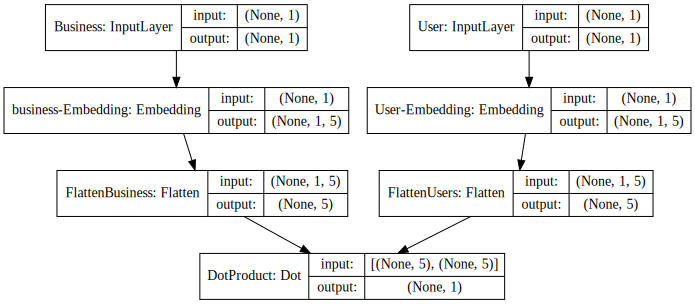

In [223]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [224]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Business (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
business-Embedding (Embedding)  (None, 1, 5)         2500        Business[0][0]                   
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         204280      User[0][0]                       
__________________________________________________________________________________________________
FlattenBus

#### train

In [236]:
history = model.fit([train.user_id, train.business_id], train.stars, epochs=100, verbose=0)

Text(0, 0.5, 'Train Error')

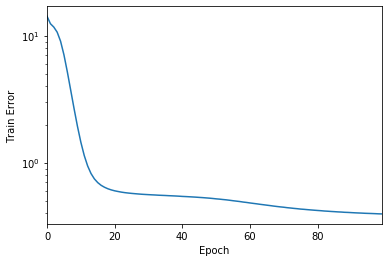

In [237]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [238]:
y_hat = np.round(model.predict([test.user_id, test.business_id]),0)
y_true = test.stars

In [239]:
np.round(model.predict([[21387], test.business_id]),0)

array([[-0.]], dtype=float32)

In [240]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

2.459821171041246

In [241]:
business_embedding_learnt = model.get_layer(name='business-Embedding').get_weights()[0]
pd.DataFrame(business_embedding_learnt).describe()

,0,1,2,3,4
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-1.786224,-1.943883,-1.838864,-1.990174,1.806344
std,0.999558,0.951664,1.161904,1.150820,1.238528
min,-3.751278,-4.289556,-5.090249,-5.336202,-1.626036
25%,-2.545964,-2.612790,-2.638820,-2.712415,1.038729
50%,-1.928630,-2.004793,-1.851157,-2.111560,1.841538
75%,-1.210229,-1.386853,-1.053700,-1.383517,2.652944
max,1.630400,1.556972,1.326942,2.391536,5.333212


In [242]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2,3,4
count,40856.000000,40856.000000,40856.000000,40856.000000,40856.000000
mean,-0.261389,-0.262061,-0.261592,-0.259915,0.259915
std,0.194471,0.189565,0.204378,0.198326,0.196759
min,-1.444574,-1.423113,-1.626124,-1.909374,-1.751477
25%,-0.406971,-0.408029,-0.412223,-0.408784,0.070948
50%,-0.307659,-0.310098,-0.309095,-0.307019,0.305154
75%,-0.075666,-0.078321,-0.059931,-0.071259,0.407778
max,1.050075,0.962363,0.956930,1.297135,1.695060


In [243]:
pd.DataFrame({'s':y_hat[:,0]}).groupby('s').agg({'s':'count'})

,s
s,
-4.0,1
-3.0,2
-1.0,8
0.0,9155
1.0,295
2.0,617
3.0,2138
4.0,3473
5.0,1350


#### non-negative matrix factorization

In [ ]:
from keras.constraints import non_neg

business_input = keras.layers.Input(shape=[1],name='Business')
business_embedding = keras.layers.Embedding(n_business + 1, n_latent_factors, name='NonNegBusiness-Embedding', embeddings_constraint=non_neg())(business_input)
business_vec = keras.layers.Flatten(name='FlattenBusiness')(business_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding', embeddings_constraint=non_neg())(user_input))

prod = keras.layers.dot([business_vec, user_vec], name='DotProduct', axes=1)
model = keras.Model([user_input, business_input], prod)
model.compile('adam', 'mean_squared_error')

#### use neural-network

In [244]:
n_latent_factors_user = 5
n_latent_factors_business = 8

business_input = keras.layers.Input(shape=[1],name='Business')
business_embedding = keras.layers.Embedding(n_business + 1, n_latent_factors_business, name='Business-Embedding')(business_input)
business_vec = keras.layers.Flatten(name='FlattenBusiness')(business_embedding)
business_vec = keras.layers.Dropout(0.2)(business_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([business_vec, user_vec], name='Concat', axis=1)
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='softmax',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, business_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

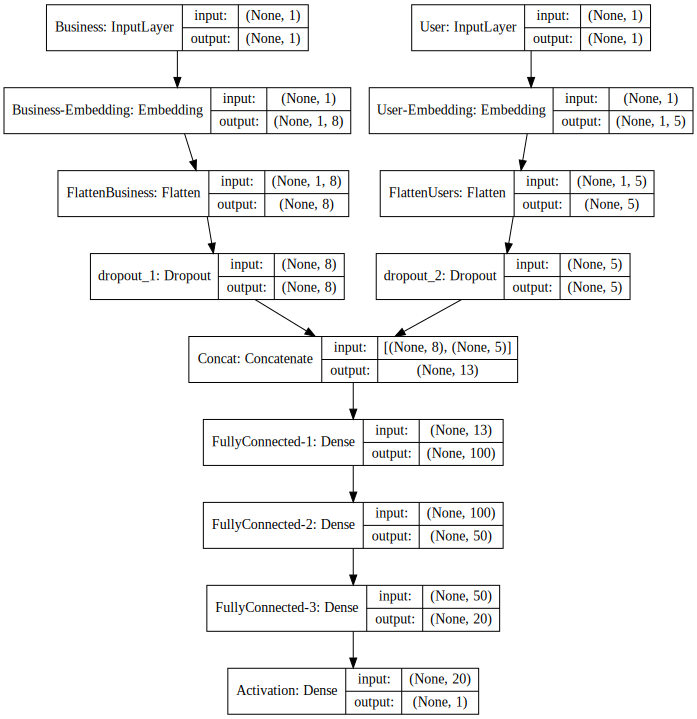

In [245]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [246]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Business (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Business-Embedding (Embedding)  (None, 1, 8)         4000        Business[0][0]                   
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         204280      User[0][0]                       
__________________________________________________________________________________________________
FlattenBus

In [247]:
history = model.fit([train.user_id, train.business_id], train.stars, epochs=250, verbose=0)

Text(0, 0.5, 'Train Error')

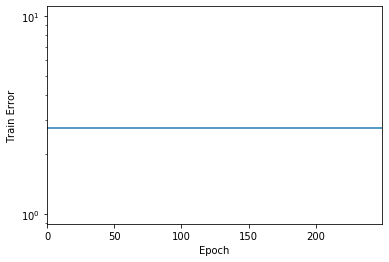

In [248]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [249]:
y_hat_2 = np.round(model.predict([test.user_id, test.business_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.business_id])))

2.7329102970868187
2.7329102970868187


In [250]:
pd.DataFrame({'s':y_hat_2[:,0]}).groupby('s').agg({'s':'count'})

,s
s,
1.0,17335


In [ ]:
test.groupby('stars').agg({'stars':'count'})

#### factorization machine

In [24]:
import keras
from keras.layers import Layer, Dense, Dropout,Input
from keras import Model,activations
from keras.optimizers import Adam
import keras.backend as K
from sklearn.datasets import load_breast_cancer

Using TensorFlow backend.


In [25]:
class FMLayer(Layer):
    def __init__(self, output_dim=30, activation="relu", **kwargs):
        self.output_dim = output_dim
        self.activate = activations.get(activation)
        super(FMLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.weight = self.add_weight(name='weight', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='bias', 
                                      shape=(self.output_dim,),
                                      initializer='zeros',
                                      trainable=True)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(FMLayer, self).build(input_shape)

    def call(self, x):
        feature =  K.dot(x,self.weight) + self.bias
        a = K.pow(K.dot(x,self.kernel), 2)
        b = K.dot(x, K.pow(self.kernel, 2))
        cross = K.mean(a-b, 1, keepdims=True)*0.5
        cross = K.repeat_elements(K.reshape(cross, (-1, 1)), self.output_dim, axis=-1)
        return self.activate(feature + cross)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [94]:
data = train
target = train['stars']

In [116]:
K.clear_session()
inputs = Input(shape=(4,))
out = FMLayer(1)(inputs)
out = Dense(15,activation="sigmoid")(out)
out = Dense(1,activation="relu")(out)

model = Model(inputs=inputs, outputs=out)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_vega_20.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
fm_layer_7 (FMLayer)         (None, 1)                 9         
_________________________________________________________________
dense_11 (Dense)             (None, 1, None, 15)       30        
_________________________________________________________________
dense_12 (Dense)             (None, 1, None, 1)        16        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


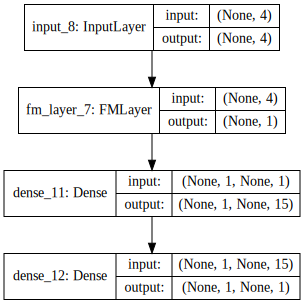

In [117]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [86]:
model.fit(data, target,
            batch_size=1,
            epochs=100,
            validation_split=0.2)

ValueError: Error when checking target: expected dense_6 to have 4 dimensions, but got array with shape (51988, 1)

-----------------------------
### Deep Factorization Model

#### load data

In [196]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_max_category = 15
n_category = 177

def load_reviews():
    df = review_restaurant.copy()
    return df[['business_id','user_id','stars','useful','funny','cool','date']]

def load_restaurants():
    df = restaurant.copy()
    df = df.rename(columns={'stars':'restaurant_stars'})
    return df[['business_id','name','restaurant_stars','review_count','categories']]

def load_users():
    df = user_restaurant.copy()
    df = df.rename(columns={'review_count':'user_review_count','useful':'user_useful','funny':'user_funny','cool':'user_cool'})
    return df[['user_id','user_review_count','user_useful','user_funny','user_cool','fans','average_stars']]

def text2seq(text, n_category):
    """ using tokenizer to encoded the multi-level categorical feature
    """
    tokenizer = Tokenizer(lower=True, split=',',filters='', num_words=n_category)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=n_max_category, padding='post')
    return seq

reviews = load_reviews()
restaurants = load_restaurants()
users = load_users()

print("====== review ======")
print(reviews.head())
print("===== restaurant ======")
print(restaurants.head())
print("====== user ======")
print(users.head())

====== review ======
              business_id                 user_id  stars  useful  funny  cool  \
0  PZ-LZzSlhSe9utkQYU8pFg  -Yz2wIcsdJxUOFMbTgoKQA    5.0       1      0     0   
1  PZ-LZzSlhSe9utkQYU8pFg  jYcf_e5p0UG0S-9gJq_tNA    4.0       1      0     0   
2  PZ-LZzSlhSe9utkQYU8pFg  nQC0JiPIk_jCooRDxpuw5A    5.0       1      0     0   
3  PZ-LZzSlhSe9utkQYU8pFg  Gv_-mtOKhWFtCjn9xFe0SQ    3.0       1      0     0   
4  PZ-LZzSlhSe9utkQYU8pFg  pabMYegF28KjHQ5hybAJ0A    3.0       1      0     0   

                 date  
0 2011-06-29 02:55:07  
1 2010-10-06 18:20:13  
2 2010-01-13 00:35:45  
3 2008-08-23 20:30:33  
4 2009-06-01 20:02:55  
===== restaurant ======
                business_id                                 name  \
17   PZ-LZzSlhSe9utkQYU8pFg           Carluccio's Tivoli Gardens   
22   KWywu2tTEPWmR9JnBc0WyQ                         Hunk Mansion   
25   tstimHoMcYbkSC4eBA1wEg  Maria's Mexican Restaurant & Bakery   
75   kANF0dbeoW34s2vwh6Umfw                         

In [197]:
restaurants['categories'] = text2seq(restaurants.categories.values, n_category=n_category).tolist()

reviews = reviews.join(restaurants.set_index('business_id'), on = 'business_id', how = 'left')
reviews = reviews.join(users.set_index('user_id'), on = 'user_id', how = 'left')

reviews.business_id = reviews.business_id.astype('category').cat.codes.values
reviews.user_id = reviews.user_id.astype('category').cat.codes.values

print("====== preprocessed data =======")
(reviews.head())

====== preprocessed data =======


,business_id,user_id,stars,useful,funny,cool,date,name,restaurant_stars,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars
0,3670,4155,5.0,1,0,0,2011-06-29 02:55:07,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",72,177,35,28,2,3.42
1,3670,345105,4.0,1,0,0,2010-10-06 18:20:13,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,32,9,5,1,2.86
2,3670,373290,5.0,1,0,0,2010-01-13 00:35:45,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",18,34,16,2,0,3.89
3,3670,130181,3.0,1,0,0,2008-08-23 20:30:33,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",149,170,59,81,24,4.05
4,3670,388821,3.0,1,0,0,2009-06-01 20:02:55,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",59,45,10,12,2,3.80


In [198]:
reviews = reviews.sample(frac=0.05)
reviews.shape

(69306, 17)

In [199]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers():
    # numerica features
    user_review_input = Input((6,), name = 'input_user_review')
    business_info_input = Input((1,), name = 'input_business_info')
    business_info_input2 = Input((1,), name = 'input_business_info2')
    num_inputs = [user_review_input, business_info_input, business_info_input2]
    
    # single level categorical features
    user_id_input = Input((1,), name = 'input_user_id')
    business_id_input = Input((1,), name= 'input_business_id')
    cat_sl_inputs = [user_id_input, business_id_input]

    # multi level categorical features
    categories_input = Input((n_max_category,), name = 'input_categories')
    cat_ml_inputs = [categories_input]

    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    
    return inputs

inputs = define_input_layers()

In [200]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d(inputs, n_user_id, n_business_id, n_categories):
    
    user_review_input, business_info_input,business_info_input2, user_id_input, business_id_input, categories_input = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(6, name = 'num_dense_1d_user_review')(user_review_input),
                    Dense(1, name = 'num_dense_1d_business_info')(business_info_input),
                    Dense(1, name = 'num_dense_1d_business_info2')(business_info_input2)]
    cat_sl_embed_1d = [Embedding(n_user_id + 1, 1, name = 'cat_embed_1d_user_id')(user_id_input),
                       Embedding(n_business_id + 1, 1, name = 'cat_embed_1d_business_id')(business_id_input)]
    cat_ml_embed_1d = [Embedding(n_categories + 1, 1, mask_zero=True, name = 'cat_embed_1d_categories')(categories_input)]

    #num_dense_1d = [Reshape((1,))(i) for i in num_dense_1d]
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

y_1d = fm_1d(inputs, 10, 10, 10)

In [201]:
def fm_2d(inputs, n_user_id, n_business_id, n_categories, k):
    
    user_review_input, business_info_input, business_info_input2, user_id_input, business_id_input, categories_input = inputs
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_user_review')(user_review_input),
                    Dense(k, name = 'num_dense_2d_business_info')(business_info_input),
                    Dense(k, name = 'num_dense_2d_business_info2')(business_info_input2)] # shape (None, k)
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)

    cat_sl_embed_2d = [Embedding(n_user_id + 1, k, name = 'cat_embed_2d_user_id')(user_id_input), 
                       Embedding(n_business_id + 1, k, name = 'cat_embed_2d_business_id')(business_id_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_categories + 1, k, name = 'cat_embed_2d_categories')(categories_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_categories_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)

    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)

    # calcuate the interactions by simplication
    # sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)

    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)

    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

y_fm2_d, embed_2d = fm_2d(inputs, 10, 10, 10, 5)

In [202]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = deep_part(embed_2d, [16, 16], 0.5)

In [203]:
def deep_fm_model(n_user_id, n_business_id, n_categories, k, dnn_dim, dnn_dr):
    
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_user_id, n_business_id, n_categories)
    y_fm_2d, embed_2d = fm_2d(inputs, n_user_id, n_business_id, n_categories, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name = 'deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

In [204]:
params = {
    'n_user_id': reviews.user_id.max(),
    'n_business_id': reviews.business_id.max(),
    'n_categories': n_category,
    'k':20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}

fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

In [205]:
def df2xy(reviews):
    x = [np.array([reviews.user_review_count.values, reviews.user_useful.values,reviews.user_funny.values,reviews.user_cool.values,reviews.fans.values,reviews.average_stars.values,]).reshape(-1,6),
         reviews.restaurant_stars.values,#np.array([reviews.restaurant_stars.values, reviews.review_count.values]).reshape(-1,2), 
         reviews.review_count.values,
         reviews.user_id.values, 
         reviews.business_id.values, 
         np.concatenate(reviews.categories.values).reshape(-1,n_max_category)]
    y = reviews.stars.values
    return x,y

in_train_flag = np.random.random(len(reviews)) <= 0.9
train_data = reviews.loc[in_train_flag,]
valid_data = reviews.loc[~in_train_flag,]
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

In [252]:
pd.DataFrame(reviews.stars.values).iloc[:,0].value_counts()

5.0    29383
4.0    16958
3.0     8586
1.0     8392
2.0     5987
Name: 0, dtype: int64

In [206]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
# train  model
deep_fm_model.compile(loss = 'MSE', optimizer='adam')

In [207]:
deep_fm_model.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_user_review (InputLayer)  [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_business_info (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_business_info2 (InputLaye [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_categories (InputLayer)   [(None, 15)]         0                                            
___________________________________________________________________________________________

In [208]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_ckp = ModelCheckpoint(filepath='./model/deepfm_weights.h5', 
                            monitor='val_loss',
                            save_weights_only=True, 
                            save_best_only=True)
callbacks = [model_ckp,early_stop]
train_history = deep_fm_model.fit(train_x, train_y, 
                                  epochs=30, batch_size=1024, 
                                  validation_split=0.1, 
                                  callbacks = callbacks)

Train on 56216 samples, validate on 6247 samples
Epoch 1/30
56216/56216 [==============================] - 10s 182us/sample - loss: 3666437607991.1567 - val_loss: 30141480.7767
Epoch 2/30
56216/56216 [==============================] - 4s 73us/sample - loss: 988937591424.8926 - val_loss: 14485753.6658
Epoch 3/30
56216/56216 [==============================] - 4s 74us/sample - loss: 288459528660.3558 - val_loss: 13386092.1101
Epoch 4/30
56216/56216 [==============================] - 4s 73us/sample - loss: 69372134262.2183 - val_loss: 13159182.8298
Epoch 5/30
56216/56216 [==============================] - 4s 72us/sample - loss: 12504488835.4063 - val_loss: 13330012.2476
Epoch 6/30
56216/56216 [==============================] - 4s 73us/sample - loss: 1532403424.0273 - val_loss: 9120392.7444
Epoch 7/30
56216/56216 [==============================] - 4s 74us/sample - loss: 235601620.4264 - val_loss: 8836539.9545
Epoch 8/30
56216/56216 [==============================] - 4s 74us/sample - loss: 6

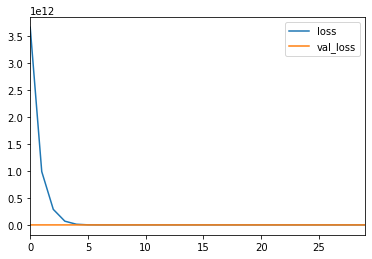

In [209]:
%matplotlib inline
pd.DataFrame(train_history.history).plot()

In [210]:
reviews

,business_id,user_id,stars,useful,funny,cool,date,name,restaurant_stars,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars
645442,3900,332628,5.0,5,5,5,2013-08-25 00:03:54,Bacchanal Buffet,4.0,8339,"[1, 36, 7, 2, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",824,3658,3672,2645,143,3.79
221191,4381,229619,5.0,1,1,1,2013-03-31 06:15:28,Monta Ramen,4.0,2604,"[54, 76, 1, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",34,28,10,15,2,4.08
951302,39,48612,5.0,0,0,0,2011-01-10 05:40:25,Pho Kinh Do,4.0,832,"[54, 1, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",16,22,5,13,0,3.76
180868,7542,9412,5.0,0,0,0,2017-02-22 16:43:12,Blaze Fast Fired Pizza,4.0,186,"[4, 8, 1, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",59,37,3,10,0,4.23
173931,2512,302447,3.0,9,6,6,2013-08-10 18:40:01,La Bonita Supermarket,3.5,130,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",507,4414,2308,3039,186,3.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457647,2838,435371,3.0,5,3,5,2016-11-15 20:38:06,Shang Artisan Noodle,4.5,1052,"[1, 54, 19, 13, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",410,2063,1240,1345,133,3.61
44754,6164,184249,5.0,3,0,3,2018-03-02 05:07:55,Chica,4.5,598,"[50, 5, 46, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",400,876,281,440,33,4.04
1299261,7708,424994,5.0,1,2,1,2012-07-07 18:55:22,Santa Fe Station Hotel & Casino,2.5,287,"[1, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",638,2131,991,1515,90,3.95
1142305,5137,57528,2.0,2,0,0,2012-10-20 20:50:05,Market Grille Cafe,4.0,453,"[33, 62, 1, 57, 40, 38, 14, 10, 0, 0, 0, 0, 0,...",316,611,147,211,11,3.30


In [248]:
weights = deep_fm_model.get_weights()
fm_1_weight, fm_2d_weigth, deep_weight = weights[-2]
print("""
contribution of different part of model
    weight of 1st order fm: %5.3f
    weight of 2nd order fm: %5.3f
    weight of dnn part: %5.3f
""" % (fm_1_weight, fm_2d_weigth, deep_weight))

ValueError: too many values to unpack (expected 3)

In [215]:
predict_y = deep_fm_model.predict(valid_x)[:,0]
sum((valid_y-predict_y)**2)/len(predict_y)

14089870.842820706

In [250]:
predict_y = deep_fm_model.predict(train_x)[:,0]
sum((train_y-predict_y)**2)/len(predict_y)

6963548.719424206

In [251]:
predict_y

array([2634.875  , -197.94893,  217.06905, ...,  -58.03833,  427.6963 ,
       1629.0302 ], dtype=float32)

In [236]:
reviews.groupby('user_id').agg({'business_id':'count'})['business_id'].value_counts()

1     44809
2      5171
3      1496
4       646
5       317
6       184
7       106
8        66
9        57
10       32
11       22
12       18
13       15
15       12
14       12
17        6
16        6
22        6
20        5
21        4
18        4
25        3
24        3
23        2
19        2
37        1
29        1
27        1
35        1
26        1
30        1
38        1
40        1
53        1
83        1
44        1
31        1
Name: business_id, dtype: int64

In [227]:
reviews['fans'].value_counts()

0      30080
1       9336
2       4719
3       2987
4       2055
       ...  
212        1
531        1
338        1
264        1
289        1
Name: fans, Length: 414, dtype: int64

In [245]:
pd.DataFrame(predict_y).describe()

,0
count,6843.000000
mean,963.859253
std,3629.119629
min,-82185.468750
25%,142.830841
50%,531.386169
75%,1352.746948
max,53088.769531


In [237]:
valid_y

array([5., 1., 5., ..., 2., 5., 5.])

In [185]:
valid_x

[array([[1.067e+03, 1.650e+02, 2.000e+00, 1.810e+02, 7.000e+00, 1.700e+01],
        [1.300e+01, 1.300e+01, 1.100e+01, 4.000e+00, 8.000e+00, 3.540e+02],
        [2.000e+00, 1.900e+01, 2.000e+00, 3.000e+01, 3.500e+01, 1.400e+01],
        ...,
        [3.500e+00, 4.020e+00, 4.020e+00, 4.220e+00, 3.760e+00, 3.670e+00],
        [1.000e+00, 3.880e+00, 3.100e+00, 1.570e+00, 2.060e+00, 3.480e+00],
        [4.500e+00, 4.200e+00, 3.770e+00, 4.260e+00, 5.000e+00, 3.150e+00]]),
 array([4., 4., 4., ..., 3., 3., 3.]),
 array([ 40,  40, 107, ..., 138, 138, 138]),
 array([ 88774, 175885, 142471, ..., 416758, 208785, 288808], dtype=int32),
 array([3670, 3670, 2975, ..., 8215, 8215, 8215], dtype=int16),
 array([[ 1, 14,  0, ...,  0,  0,  0],
        [ 1, 14,  0, ...,  0,  0,  0],
        [ 3,  0,  0, ...,  0,  0,  0],
        ...,
        [ 2,  6,  0, ...,  0,  0,  0],
        [ 2,  6,  0, ...,  0,  0,  0],
        [ 2,  6,  0, ...,  0,  0,  0]])]

(array([2.000e+00, 2.000e+00, 5.000e+00, 4.000e+00, 1.400e+01, 2.180e+02,
        6.554e+03, 3.300e+01, 5.000e+00, 6.000e+00]),
 array([-82185.47  , -68658.05  , -55130.62  , -41603.195 , -28075.773 ,
        -14548.35  ,  -1020.9258,  12506.498 ,  26033.922 ,  39561.344 ,
         53088.77  ], dtype=float32),
 <a list of 10 Patch objects>)

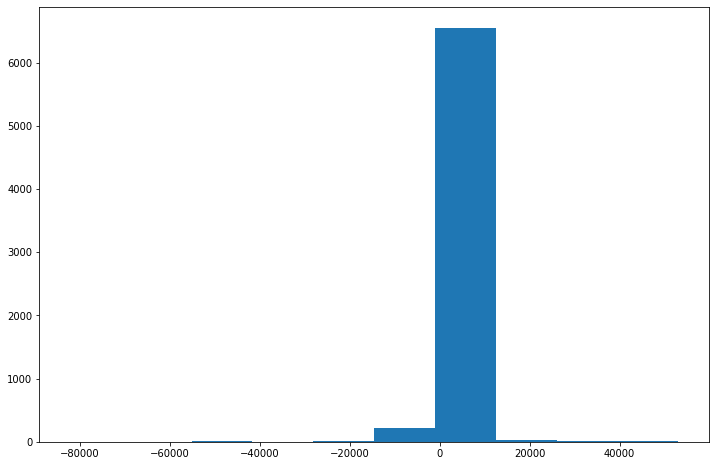

In [216]:
plt.figure(figsize=(10,6))
plt.hist(predict_y)

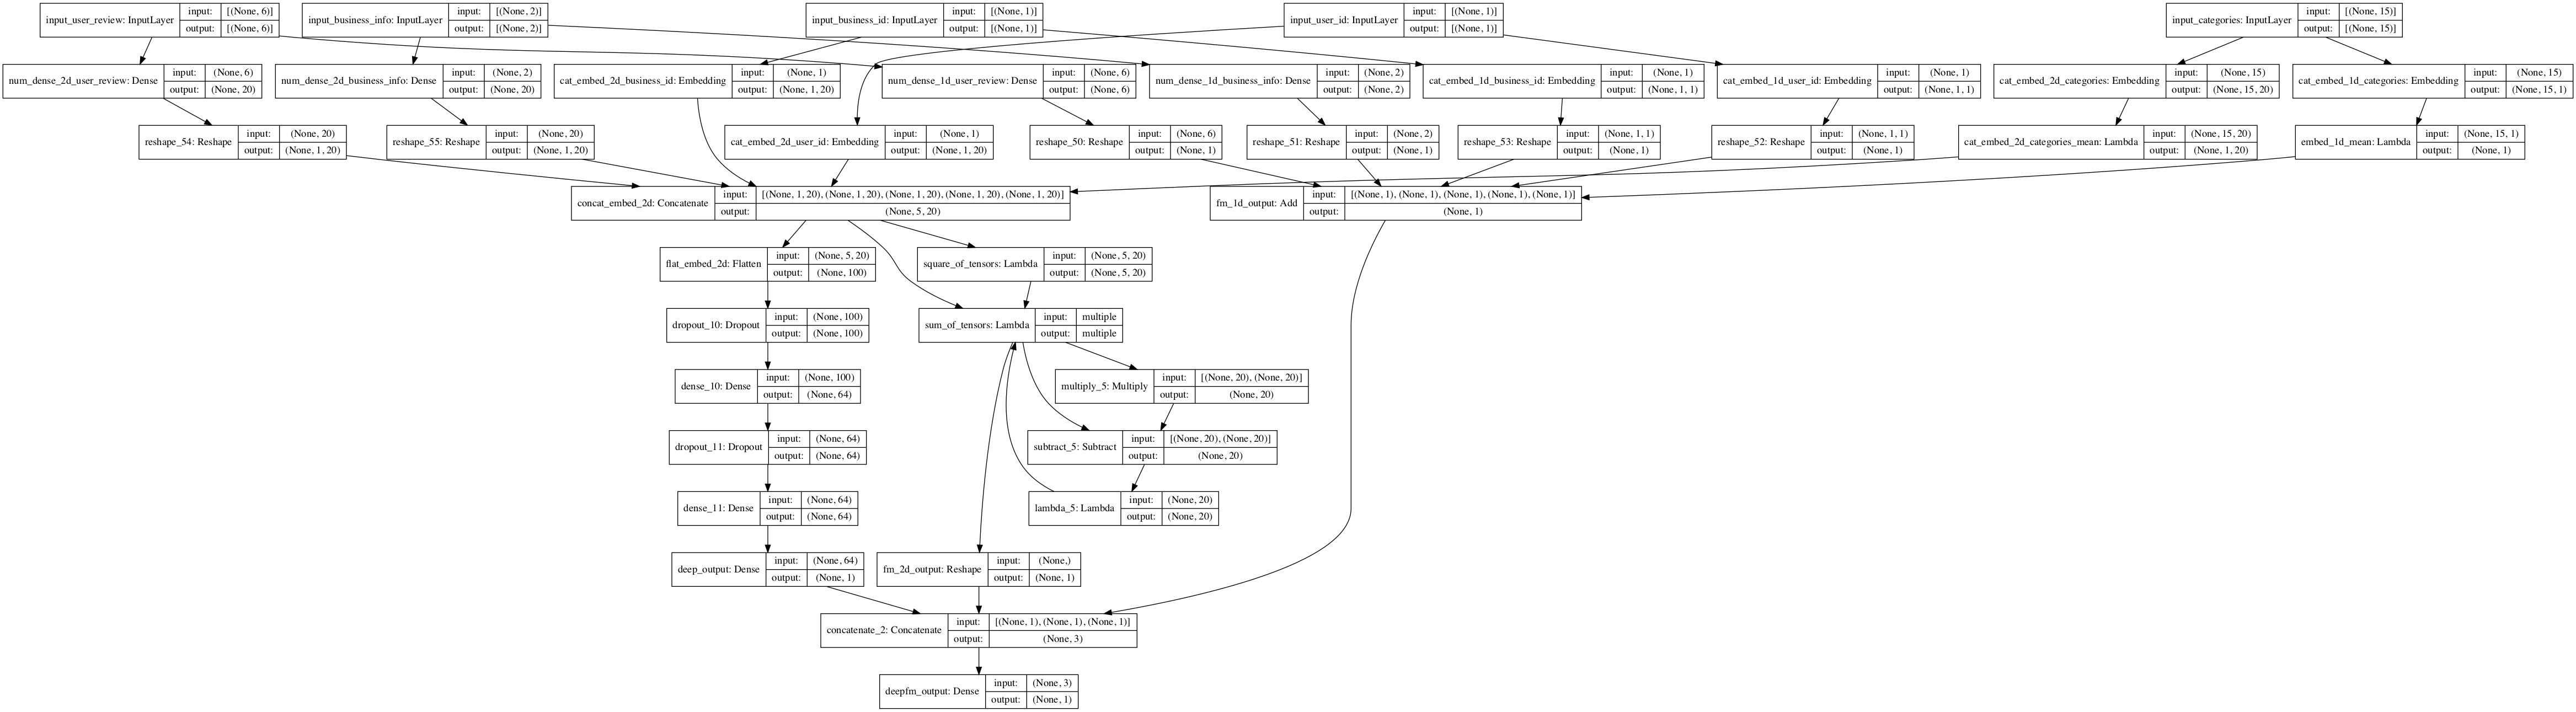

In [118]:
!rm -rf image
!mkdir image
from tensorflow.keras.utils import plot_model
plot_model(fm_model_1d, to_file='./image/fm_model_1d.png',show_shapes=True, show_layer_names=True)
plot_model(fm_model_2d, to_file='./image/fm_model_2d.png',show_shapes=True, show_layer_names=True)
plot_model(deep_model, to_file='./image/deep_model.png',show_shapes=True, show_layer_names=True)
plot_model(deep_fm_model, to_file='./image/deep_fm_model.png',show_shapes=True, show_layer_names=True)

In [239]:
reviews['business_id'].nunique()

6450

In [240]:
reviews.groupby('user_id').agg({'business_id':'count'}).describe()

,business_id
count,53016.000000
mean,1.307266
std,1.238453
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,83.000000


(array([5.2852e+04, 1.2300e+02, 2.9000e+01, 5.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  9.2, 17.4, 25.6, 33.8, 42. , 50.2, 58.4, 66.6, 74.8, 83. ]),
 <a list of 10 Patch objects>)

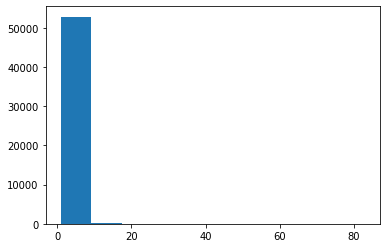

In [243]:
plt.hist(reviews.groupby('user_id').agg({'business_id':'count'})['business_id'])

In [201]:
predict_y = predict_y[:,0]

IndexError: too many indices for array

In [79]:
sum((valid_y-predict_y)**2)/len(predict_y)

0.867385378353822

In [80]:
predict_y = deep_fm_model.predict(valid_x)[:,0]
sum((valid_y-predict_y)**2)/len(predict_y)

In [202]:
predict_y

array([3.8843737, 4.36976  , 4.231337 , ..., 4.907035 , 4.272271 ,
       3.549511 ], dtype=float32)

In [211]:
len(train_x[0])+len(valid_x[0])

1386124